# Restricted Boltzmann Machines

RBM is an Energy based model which associates a scalar energy to each configuration of variables of interest. <br><br>
A RBM has a visible layer $v$ and a hidden layer $h$
We have three equations of interest:<br><br>
We define a probability distribution which tells us the probability of similarity of the original input to the generated output from the hidden layer.<br><br>

We define a joint distribution using the visible and hidden variable:<br><br>

$ p(v,h) = \frac{1}{Z} exp\{ -E(v,h)\} $<br><br>

Where $ E(v,h) $ is the energy function<br><br>

$ E(v,h) = -b^Tv - c^Th - v^TWh $<br><br>

Where, $b$ represents the $k$ nodes of the visible later and $c$ represents the $j$ nodes of the hidden layer.$b$ and $c$ are called bias vectors.<br><br>


Z is the normalizing partition function:<br><br>

$Z = \sum_v \sum_h exp\{ -E(v,h)\}$:<br><br>


We want to increase $p(v,h)$ i.e decrease the energy function.<br><br>

Sometimes, $x$ is only partially observable, so we introduce some non-observed variables into our model to make it robust. So, we consider an observed part and a $hidden$ part $h$ as:<br><br>

$P(x) = \sum_h \sum_v P(x,h) = \sum_h \frac{e^{-E(x,h)}}{Z}$ --- eq. 1<br><br>

This defines free energy for us, given by:<br><br>

$F(x) = -log \sum_h e^{-E(x,h)}$ --- eq. 2<br><br>

The data negative log-likelihood takes the form after substituting 2 in 1:<br><br>

$\frac {\partial log p(x)}{\partial \theta} = \frac{\partial F(x)}{\partial \theta} = -\sum p(x')\frac{\partial F(x')}{\partial \theta}$<br><br>

The above has two terms, called the positive phase and the negative phase respectively.<br><br>


$ E(v,h) = -b^Tv - c^Th - v^TWh  = -\sum_k b_kv_k - \sum_j c_jh_j - \sum_j\sum_k W_{jk}h_jv_k$<br><br>

We want the first 2 terms in the RHS to be as large as possible to maximize probability<br><br>

Therefore, if $b$ is negative, we want to keep $v$ to be 0 and 1. Likewise, for the $c$ and $h$ pair.<br><br>

Now, if $W_{jk}$ is negative, we want either $h$ or $v$ be 0 or both.<br><br>

If $W_{jk}$ is positive, we want both  $h$ and $v$ to be 1.<br><br>

$Z = \sum_v \sum_h exp\{ -E(v,h)\}$:<br><br>
is intractable but conditional probability is easy to compute and sample from.<br><br>

So we consider: <br><br>
$P(h|v)$<br><br>
We use Gibbs sampling for this purpose, since we know how to sample from $P(h|v)$ and $P(v|h))$ but we want $P(h,v)$
$p(h|v) = \prod_j p(h_j|v)$<br><br>
$p(v|h) = \prod_k p(v_k|h)$<br><br>

In our implementation, we use binary units(where $v_k$ and $h_j\epsilon \{ 0,1 \}$)<br><br>

It was explained above when we want $h$ or $v$ to be $0$ or $1$, thus a probabilistic verion of the neuron activation function is:<br><br>

$P(h_j) = 1|v = sigm (c_j + W_jv)$<br><br>
$P(v_k) = 1|h = sigm (b_k + W'_kh)$<br><br>

The free-energy of the RBM then becomes:<br><br>
$F(v) = -b'v = \sum_i log(1 + e^{c_i + E_iv})$<br><br>


In our implementation,we use the following updation equations. We obtain the following log-likelihood gradients for an RBM with binary units:<br><br>

We estimate the negative phae gradient denoted by $N$ which can b written as :<br><br>

$- \frac{\partial log p(v)}{\partial \theta} \sim \frac{\partial F(x)}{\partial \theta} - \frac{1}{|N|} \sum_{x' \epsilon N} \frac{\partial F(x')}{\partial \theta}$<br><br>

Combining the above equation with the free-energy equation, we get:<br><br>

$-\frac{\partial log p(v)}{\partial W_{jk}} = E_v[p(h_k|v) v_j] - v^k_j sigm (W_iv^i  + c_i)$<br><br>


$ - \frac{\partial log p(v)}{\partial c_k}=  E_v[p(h_k|v)] - sigm(W_k v^k)$<br><br>

$- \frac{\partial log p(v)}{\partial b_j}= E_v[p(v_j|h)] - v^k_j$<br><br>


We obtain the samples of $p(x)$ running a markov chain to convergence , using Gibbs sampling<br><br>

Gibbs sampling of the joint of N random variables$ S = (S_1, ... , S_N)$ is done through a sequence of N sampling sub-steps of the form $S_i \approx p(S_i|S_{-i}) $ where $S_{-i}$ contains the $ N - 1$ other random variables in $S$ excluding $S_i$.<br><br>

$S$ consists of visible and hidden units. We can perform block Gibbs sampling on them since they are conditionally independent.<br><br>

The step we use in the makov chain is:<br><br>

$h^{(n+1)} \sim sigm(W'v^{(n)} + c) $<br><br>
$v^{(n+1)} \sim sigm(W h^{(n+1)} + b)$<br><br>

Here, $h^n$ is set of all hidden units at the n-th step of the markov chain.<br><br>

We then apply Contrastive divergence, which speeds up the sampling process.<br><br>

Since we eventually want $p(v) \approx p_{train}(v)$.<br><br>
CD does not wait for the chain to converge. Samples are obtained after only k-steps of Gibbs sampling. In pratice, $k=1$ works well.

















In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
import gzip, struct
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [0]:
#A class to handle the large dataset, create, switch batches and to remove a percentage of pixels from the input images.
class DataSet:
    batch_i = 0
    def __init__(self, data_dir, batch_size = None, one_hot = False, seed = 0):
        self.data_dir = data_dir
        X, Y = self.read()
        shape = X.shape
        X = X.reshape([shape[0], shape[1] * shape[2]])
        self.X = X.astype(np.float)/255
        self.size = self.X.shape[0]
        if batch_size == None:
            self.batch_size = self.size
        else:
            self.batch_size = batch_size

        self.batch_number = int(self.size / self.batch_size)
        # shuffle samples
        np.random.seed(seed)
        np.random.shuffle(self.X)
        np.random.seed(seed)
        np.random.shuffle(Y)
        self.one_hot = one_hot
        if one_hot:
            y_vec = np.zeros((len(Y), 10), dtype=np.float)
            for i, label in enumerate(Y):
                y_vec[i, Y[i]] = 1.0
            self.Y = y_vec
        else:
            self.Y = Y
    
    #Function to remove random pixels
    def remove_pixels(self, percent):
        num_remove = percent*784
        rand_nums = [np.random.randint(0,783) for i in range(int(num_remove))]
        for image_index in range(len(self.X)):
             for indices in rand_nums:
                  self.X[image_index][indices] = 0
      
    def change_batch(self):
        start = self.batch_i * self.batch_size
        end = (self.batch_i + 1) * self.batch_size
        self.batch_i = (self.batch_i + 1) % self.batch_number
        if self.one_hot:
            return self.X[start:end, :], self.Y[start:end, :]
        else:
            return self.X[start:end, :], self.Y[start:end]
        
    def sample_batch(self):
        index = random.randrange(self.batch_number)
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        if self.one_hot:
            return self.X[start:end, :], self.Y[start:end, :]
        else:
            return self.X[start:end, :], self.Y[start:end]
    
    def read(self):
        with gzip.open(self.data_dir['Y']) as flbl:
            magic, num = struct.unpack(">II", flbl.read(8))
            label = np.fromstring(flbl.read(), dtype=np.int8)
        with gzip.open(self.data_dir['X'], 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
        return image,label

In [4]:

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

train_dir = {
    'X': './MNIST_data/train-images-idx3-ubyte.gz', 
    'Y': './MNIST_data/train-labels-idx1-ubyte.gz'
}

train_data = DataSet(data_dir=train_dir, batch_size=64, one_hot=True)

test_dir = {
	'X': './MNIST_data/t10k-images-idx3-ubyte.gz', 
	'Y': './MNIST_data/t10k-labels-idx1-ubyte.gz'
}

test_data = DataSet(data_dir=test_dir, batch_size=64, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [0]:
class RBM():
    likelihood_index = 0 #Index for computing likelihood
  
    def __init__(self, visible_nodes=784, hidden_nodes=500, k=30, momentum=False):
        self.visible_nodes = visible_nodes
        self.hidden_nodes = hidden_nodes
        self.k = k
        
        # Momentum for learning
        self.lr = tf.placeholder(tf.float32)
        if momentum:
            self.momentum = tf.placeholder(tf.float32)
        else:
            self.momentum = 0.0

        # Define weights and biases
        self.w = tf.Variable(tf.truncated_normal([visible_nodes, hidden_nodes], stddev=0.1), name='w')

        self.hidden_bias = tf.Variable(tf.constant(0.1, shape=[hidden_nodes]), name='hidden_bias')
        self.visible_bias = tf.Variable(tf.constant(0.1, shape=[visible_nodes]), name='visible_bias')

        # The velocities of momentum
        self.w_v = tf.Variable(tf.zeros([visible_nodes, hidden_nodes]), dtype=tf.float32)
        self.hidden_b_velocities = tf.Variable(tf.zeros([hidden_nodes]), dtype=tf.float32)
        self.visible_b_velocities = tf.Variable(tf.zeros([visible_nodes]), dtype=tf.float32)

    #Propogating the values from hidden layer back to visible layer
    def down_propogation(self,hidden):
        p_sigm_activation = tf.matmul(hidden, tf.transpose(self.w)) + self.visible_bias
        return tf.nn.sigmoid(p_sigm_activation)
    #Propogating values from visible layer to hidden layer
    def up_propogation(self,visible):
        p_sigm_activation = tf.matmul(visible, self.w) + self.hidden_bias
        return tf.nn.sigmoid(p_sigm_activation)

    def sample_h_given_v(self,v_sample):
        h_props = self.up_propogation(v_sample)
        h_sample = tf.nn.relu(tf.sign(h_props - tf.random_uniform(tf.shape(h_props))))
        return h_sample

    def sample_v_given_h(self,h_sample):
        v_props = self.down_propogation(h_sample)
        v_sample = tf.nn.relu(tf.sign(v_props - tf.random_uniform(tf.shape(v_props))))
        return v_sample

    def f_energy(self,visible_nodes):
        first_term = tf.matmul(visible_nodes, tf.reshape(self.visible_bias, [tf.shape(self.visible_bias)[0], 1]))
        second_term = tf.reduce_sum(tf.log(1 + tf.exp(self.hidden_bias + tf.matmul(visible_nodes, self.w))), axis=1)
        return - first_term - second_term

    def likelihood(self,visibles):
        x = tf.round(visibles)
        free_energy_x = self.f_energy(x)
        split0, split1, split2 = tf.split(x, [self.likelihood_index, 1, tf.shape(x)[1] - self.likelihood_index - 1], 1)
        xi = tf.concat([split0, 1 - split1, split2], 1)
        self.likelihood_index = (self.likelihood_index + 1) % self.visible_nodes
        free_energy_i = self.f_energy(xi)
        return tf.reduce_mean(self.visible_nodes * tf.log(tf.nn.sigmoid(free_energy_i - free_energy_x)), axis=0)

    def contrastive_divergence(self,visible_nodes):       
        # Gibbs sampling
        v_samples = visible_nodes
        h_samples = self.sample_h_given_v(v_samples)
        for i in range(self.k):
            v_samples = self.sample_v_given_h(h_samples)
            h_samples = self.sample_h_given_v(v_samples)

        h0_props = self.up_propogation(visible_nodes)
        w_positive_grad = tf.matmul(tf.transpose(visible_nodes), h0_props)
        w_negative_grad = tf.matmul(tf.transpose(v_samples), h_samples)
        weight_gradient = (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(visible_nodes)[0])
        hidden_gradient = tf.reduce_mean(h0_props - h_samples, 0)
        visible_bias_grad = tf.reduce_mean(visible_nodes - v_samples, 0)
        return weight_gradient, hidden_gradient, visible_bias_grad

    def learn_code(self,visible_nodes):
        weight_gradient, hidden_gradient, visible_bias_grad = self.contrastive_divergence(visible_nodes)
        # New velocities
        new_velocitites = self.momentum * self.w_v + self.lr * weight_gradient
        new_hidden_velocitites = self.momentum * self.hidden_b_velocities + self.lr * hidden_gradient
        new_visible_velocitites = self.momentum * self.visible_b_velocities + self.lr * visible_bias_grad
        # Update all parameters
        update_w = tf.assign(self.w, self.w + new_velocitites)
        update_hidden_bias = tf.assign(self.hidden_bias, self.hidden_bias + new_hidden_velocitites)
        update_vb = tf.assign(self.visible_bias, self.visible_bias + new_visible_velocitites)
        # Update velocities
        update_w_v = tf.assign(self.w_v, new_velocitites)
        update_hidden_b_velocities = tf.assign(self.hidden_b_velocities, new_hidden_velocitites)
        update_visible_b_velocities = tf.assign(self.visible_b_velocities, new_visible_velocitites)

        return [update_w, update_hidden_bias, update_vb, update_w_v, update_hidden_b_velocities, update_visible_b_velocities]

    def sample_generator(self,visible_nodes, steps=5000):
        visible_samples = visible_nodes
        for step in range(steps):
            visible_samples = self.sample_v_given_h(self.sample_h_given_v(visible_samples))
        return visible_samples




In [0]:
def plot_images(images, size):
    img = (images + 1.0) / 2.0
    height, width = img.shape[1], img.shape[2]

    new_image = np.zeros((height * size[0], width * size[1]))

    for index, image in enumerate(images):
        i = index % size[1]
        j = int(index / size[1])
        new_image[j*height:j*height+height, i*width:i*width+width] = image
    
    plt.figure()
    plt.imshow(new_image,cmap = 'gray')
    plt.show()

In [0]:
#Function to train the model and generate new images taking input as images from a test set
def train(train_data, epochs,remove_percent = 0, hnodes = 500):
    # Initialize markov chain start state
    noise_x, _ = train_data.sample_batch()
    if remove_percent is not 0:
        train_data.remove_pixels(remove_percent)
    # Define the computation graph
    x = tf.placeholder(tf.float32, shape=[None, 784])
    rbm_obj = RBM(hidden_nodes = hnodes)
    step = rbm_obj.learn_code(x)
    sample_gen = rbm_obj.sample_generator(x)
    pl = rbm_obj.likelihood(x)
    epoch = 1
    
    with tf.Session() as cur_session:
        mean_cost = []
        
        init = tf.global_variables_initializer()
        cur_session.run(init)
        for i in range(epochs * train_data.batch_number):
            # Draw samples for plotting
            if i % 500 == 0:
                samples = cur_session.run(sample_gen, feed_dict = {x: noise_x})
                samples = samples.reshape([train_data.batch_size, 28, 28])
                #Uncomment below line to plot images at the end of each epoch
                plot_images(samples, [8, 8])
                
            batch_x, _ = train_data.change_batch()
            cur_session.run(step, feed_dict = {x: batch_x, rbm_obj.lr: 0.1})
            cost = cur_session.run(pl, feed_dict = {x: batch_x})
            mean_cost.append(cost)

            
            if i is not 0 and train_data.batch_i is 0:
                print('Epoch: ' + str(epoch) +'\nCost:  ' +  str(np.mean(mean_cost)))
                mean_cost = []
                epoch += 1

        # Draw testing samples
        print('Generated sample')
        samples = cur_session.run(sample_gen, feed_dict = {x: noise_x})
        samples = samples.reshape([train_data.batch_size, 28, 28])
        plot_images(samples, [8, 8])
       

The last image printed is the generated sample. The other images show random sample between RBM epochs as well as the cost at that epoch.<br><br>
Run the Restricted Boltzmann Machine using MNIST training data with 20 hidden nodes.<br><br>
Running the code with 30-40 epochs would be time-consuming but would give us satisfying results.<br><br>

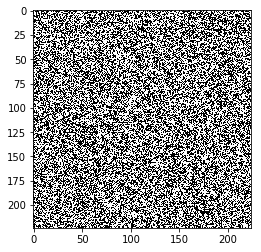

Epoch: 1
Cost:  -16.605066


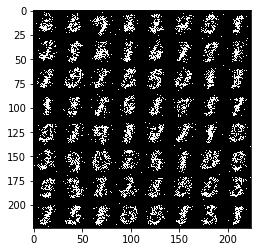

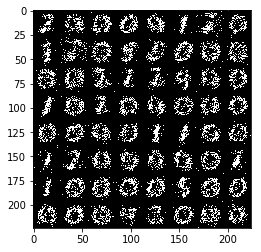

Epoch: 2
Cost:  -1.502344


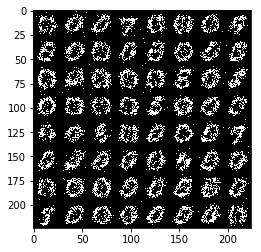

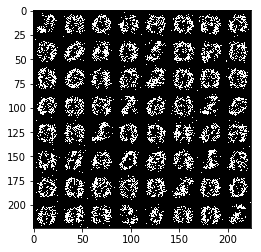

Epoch: 3
Cost:  -0.8478582


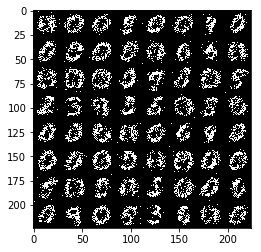

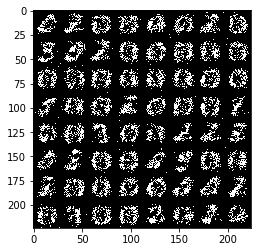

Epoch: 4
Cost:  -0.6185365


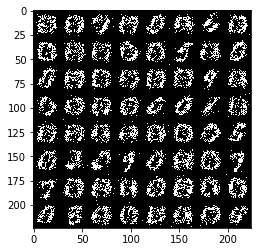

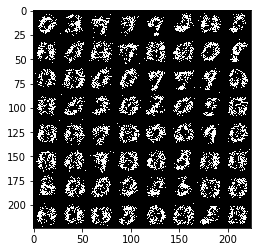

Epoch: 5
Cost:  -0.47472823


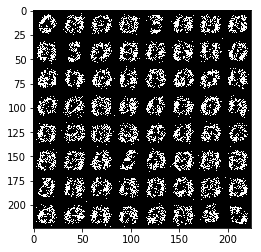

Generated sample


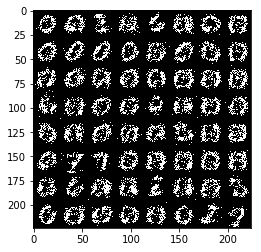

In [18]:
train(train_data, 5, remove_percent = 0, hnodes = 20)

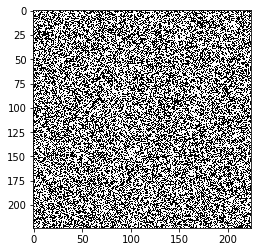

Epoch: 1
Cost:  -10.478418


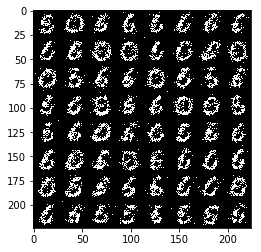

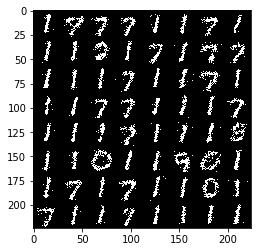

Epoch: 2
Cost:  -0.98663557


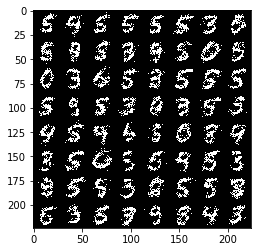

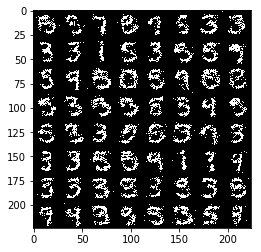

Epoch: 3
Cost:  -0.37286335


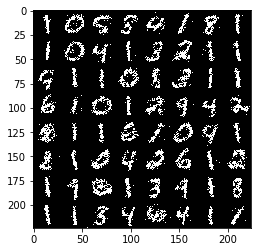

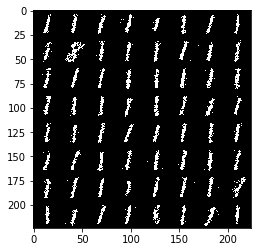

Epoch: 4
Cost:  -0.22222246


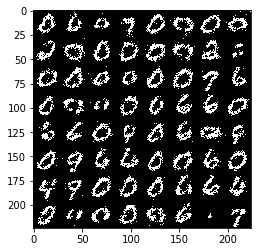

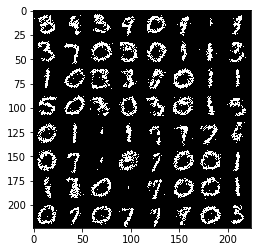

Epoch: 5
Cost:  -0.15989842


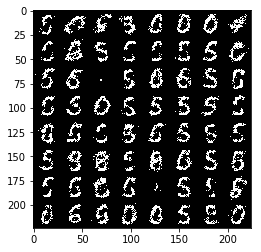

Generated sample


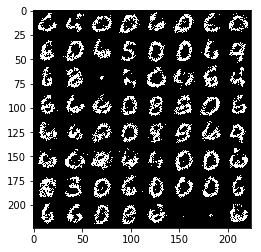

In [19]:
#Run the Restricted Boltzmann Machine using MNIST training data with 100 hidden nodes
train(train_data, 5, remove_percent = 0, hnodes = 100)

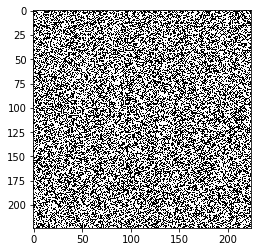

Epoch: 1
Cost:  -6.439199


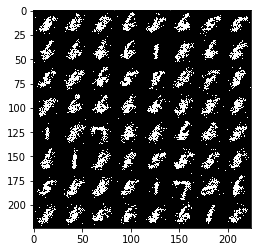

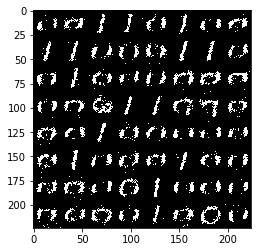

Epoch: 2
Cost:  -0.8016512


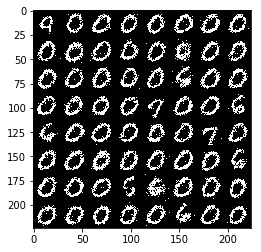

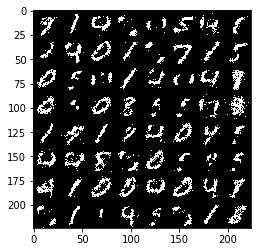

Epoch: 3
Cost:  -0.29069152


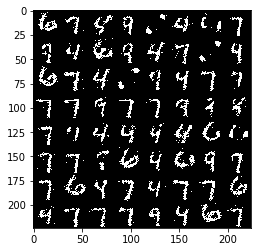

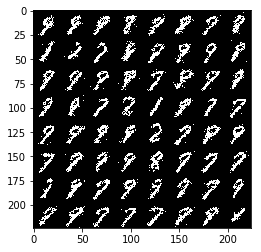

Epoch: 4
Cost:  -0.17674178


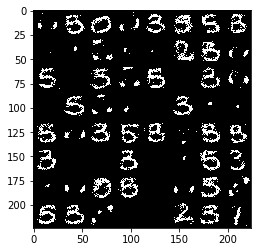

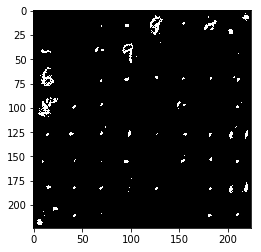

Epoch: 5
Cost:  -0.12865564


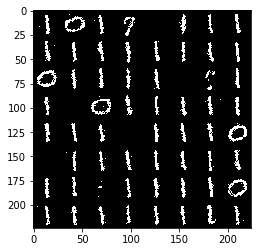

Generated sample


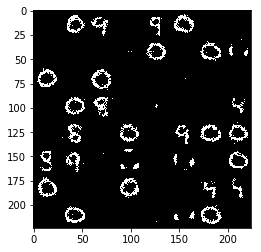

In [20]:
#Run the Restricted Boltzmann Machine using MNIST training data with 500 hidden nodes
train(train_data, 5, remove_percent = 0, hnodes = 500)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


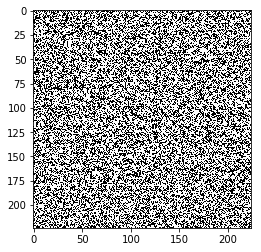

Epoch: 1
Cost:  -7.7213535
Epoch: 2
Cost:  -2.4424214
Epoch: 3
Cost:  -1.6256366


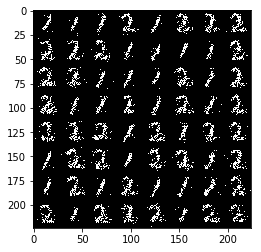

Epoch: 4
Cost:  -0.9955456
Epoch: 5
Cost:  -0.73245853
Epoch: 6
Cost:  -0.70434624


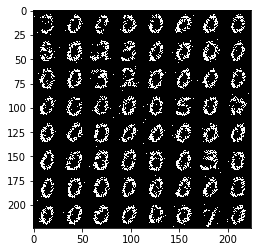

Epoch: 7
Cost:  -0.5599681
Epoch: 8
Cost:  -0.49090624
Epoch: 9
Cost:  -0.4233706


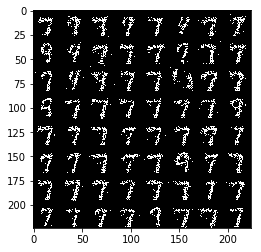

Epoch: 10
Cost:  -0.3831142
Generated sample


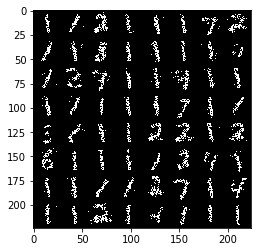

In [9]:
#Run the Restricted Boltzmann Machine using MNIST test data with 20% of the pixels removed
train(test_data, 10, remove_percent = 0.2)

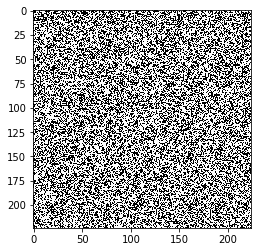

Epoch: 1
Cost:  -0.87114704
Epoch: 2
Cost:  -0.9631514
Epoch: 3
Cost:  -1.019524


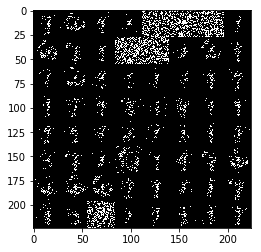

Epoch: 4
Cost:  -0.97995883
Epoch: 5
Cost:  -0.8271503
Epoch: 6
Cost:  -0.72307026


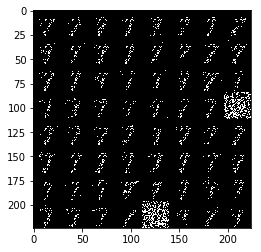

Epoch: 7
Cost:  -0.58069634
Epoch: 8
Cost:  -0.4847035
Epoch: 9
Cost:  -0.44703278


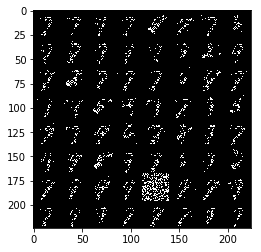

Epoch: 10
Cost:  -0.42473692
Generated sample


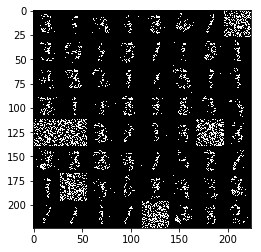

In [10]:
#Run the Restricted Boltzmann Machine using MNIST test data with 50% of the pixels removed
train(test_data, 10, remove_percent = 0.5)

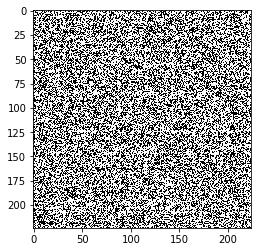

Epoch: 1
Cost:  -4.187026
Epoch: 2
Cost:  -1.17463
Epoch: 3
Cost:  -0.9050973


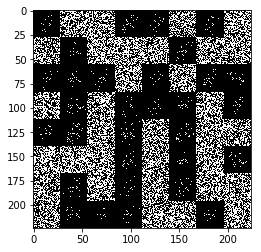

Epoch: 4
Cost:  -0.67311084
Epoch: 5
Cost:  -0.49595925
Epoch: 6
Cost:  -0.37829548


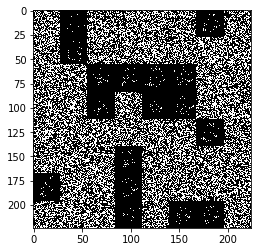

Epoch: 7
Cost:  -0.38106838
Epoch: 8
Cost:  -0.29125214
Epoch: 9
Cost:  -0.26114076


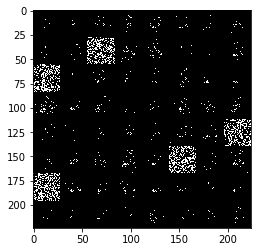

Epoch: 10
Cost:  -0.3408397
Generated sample


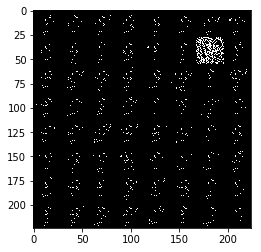

In [11]:
#Run the Restricted Boltzmann Machine using MNIST test data with 80% of the pixels removed
train(test_data, 10,0.8)

As we can see, when a higher percentage of pixels are removed from the input images, the generated images are not very satisfactory at lower number of epochs.

References: <br>
http://lyy1994.github.io/machine-learning/2017/04/17/RBM-tensorflow-implementation.html<br>
https://www.youtube.com/watch?v=FJ0z3Ubagt4<br>
http://deeplearning.net/tutorial/rbm.html<br>

# Variational Autoencoder

The variational autoencoder

The goal of the Variational autoencoder is to find the distribution of the latent variables $q(z|x)$<br><br>
The aim is to find $ p(z|x) = \frac{p(x|z) p(z)}{p(x)} $ <br><br>
Solving the RHS is an intractable problem, so we approximate $ p(z|x) $ to a distribution $ q(z) $<br><br> 
Once the distribution $ q(z) $ is found, we sample value $ z $<br><br>
We want q to be similar to $ p(z|x) $<br><br>
So, we minimize the Kullback-Leibler divergence which is a measure of difference of the distributions.<br><br>
$ min KL( q(z) || p(z|x)) $<br><br>
By definition of KL Divergence: <br><br>
$ min KL( q(z) || p(z|x)) = - \sum q(z) log \frac {p(z|x)}{q(z)} $ ---Equation 1<br><br>
Also, $ p(z|x) = \frac{p(x,z)}{p(x)} $ ---Equation 2<br><br>
Substitute eq. 2 in 1 <br><br>
$ min KL( q(z) || p(z|x)) = - \sum q(z) log \frac { \frac{p(x,z)}{p(x)} }{q(z)} = - \sum q(z) log \frac{p(x,z)}{q(z)} \frac{1}{p(x)} $<br><br>
$ = - \sum q(z) \Big[ log(\frac{p(x,z)}{q(z)}) - log(p(x))\Big] $<br><br>
$  = - \sum q(z) log(\frac{p(x,z)}{q(z)}) + \sum_z q(z) log(p(x)) = - \sum q(z) log(\frac{p(x,z)}{q(z)}) + log(p(x))  $<br><br>
So, we can write the above as:<br><br>
$ log(p(x)) = KL(q(z) || p(z|x)) + \sum q(z) log(\frac{p(x,z)}{q(z)}) $<br><br>
The second term is called Variational lower bound. Minimizing the KL term is equivalent to maximising the Variational lower bound.<br><br>
Now, consider the variational lower bound<br><br>
$\sum q(z) log(\frac{p(x,z)}{q(z)} = \sum q(z) log p(x|z) + \sum q(z) log(\frac{p(z)}{q(z)}$<br><br>
The term on the right is $ - KL(q(z)||p(z))$<br><br>
The term on the left is the Expectation $ E_{q(z)} p(x|z)  $ is the reconstruction error and is represented by binary crossentropy.<br><br>
So, the lower bound becomes $ E_{q(z)} p(x|z) - KL(q(z)||p(z))$<br><br>
We will use the reconstruction loss and the kl divergence as our loss function in our implementation.

$q((z|x)$ will be part of the neural network called encoder and the decoder is $p(x|z)$ <br><br>

We assume a gaussian distribution so the output of out VAE which is encoder+decoder is in a gaussian form.<br><br>

Thus, the aim of out autoencoder is to minimize the sum of the reconstruction loss and KL divergence which will be of the form $ Gaussian distribution + KL Divergence $<br><br>

$ min(|x-x'|^2  + KL(q(z|x)||N(\mu,\sigma^2))) $<br><br>

So, now we consider only the decoder part of of our VAE which is $generative$. We sample values from the output of th encoder and generate similar outputs.



# Using Dimensions <br> Input Layer:784 <br> Latent variables:2 <br> Output Layer: 784 <br> Hidden layer: 256

In [0]:
from keras.layers import Lambda, Input, Dense
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
def epsilon_gen(latents):
    #We implement the reparameterization trick
    #We pick a random unit gaussian and shift it by the amount defined by the mean and variance
    latent_mean, latent_log_var = latents
    #Use keras backend
    batch = K.shape(latent_mean)[0]
    dim = K.int_shape(latent_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    #Return the shifted unit gaussian
    return z_mean + K.exp(0.5 * latent_log_var) * epsilon

In [0]:
def plot_results(lat_dim,models,
                 data,
                 batch_size=128):
    encoder = models[0]
    decoder = models[1]
    
    x_test = data[0]
    y_test = data[1]
    
    #Data to create a scatterplot of the digit classes.
    scatter_param, _, _ = encoder.predict(x_test,batch_size=batch_size)
    
    plt.figure(figsize=(14, 12))
    plt.scatter(scatter_param[:, 0], scatter_param[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("Mean-0")
    plt.ylabel("Mean-1")
    plt.show()

    
    image_size = 28
    n = 30
    mygrid = np.zeros((image_size * n, image_size * n))
    #Display a grid of the digits
    
    #We vary the mean and variance from -3 to 3 and print results
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    
    for i, variance in enumerate(grid_y):
        for j, means in enumerate(grid_x):
            if lat_dim == 1:
                z_sample = np.array([[means,variance]*lat_dim])
            else:
                z_sample = np.random.normal(0,1,size = [batch_size,lat_dim*2])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(image_size, image_size)
            mygrid[i * image_size: (i + 1) * image_size,
                   j * image_size: (j + 1) * image_size] = digit   
    
    
    plt.figure(figsize=(10, 10))
    start_range = image_size // 2
    end_range = (n - 1) * image_size + start_range + 1
    tick_vals = np.arange(start_range, end_range, image_size)
    
    rangeof_x = np.round(grid_x, 1)
    rangeof_y = np.round(grid_y, 1)
    
    #Print the axis values
    plt.xticks(tick_vals, rangeof_x)
    plt.yticks(tick_vals, rangeof_y)
    
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.imshow(mygrid, cmap='Greys')
    plt.show()

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#MNIST images are of size 28x28
image_size = 28
original_dim = image_size * image_size

#Now, we flatten/unroll and normalize the images
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Define parameters
input_size = (original_dim, )
intermediate_dim = 256
batch_size = 128
latent_dim = 2
epochs = 2




# Create encoder model

In [0]:
inputs = Input(shape=input_size)
x = Dense(intermediate_dim, activation='relu')(inputs)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

#Epsilon gen generates a shifted unit gaussian eliminating the need for solving a intranctable problem
z = Lambda(epsilon_gen, name='z')([z_mean, z_log_var])

# We create the encoder object here
encoder = Model(inputs, [z_mean, z_log_var, z])

# Create decoder model

In [0]:

latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# We create the decoder model here
decoder = Model(latent_inputs, outputs)

# The VAE model is a combination of encoder and decoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 19s 320us/step - loss: 208.7336 - val_loss: 180.9483
Epoch 2/2
60000/60000 [==============================] - 12s 194us/step - loss: 175.5002 - val_loss: 170.5561


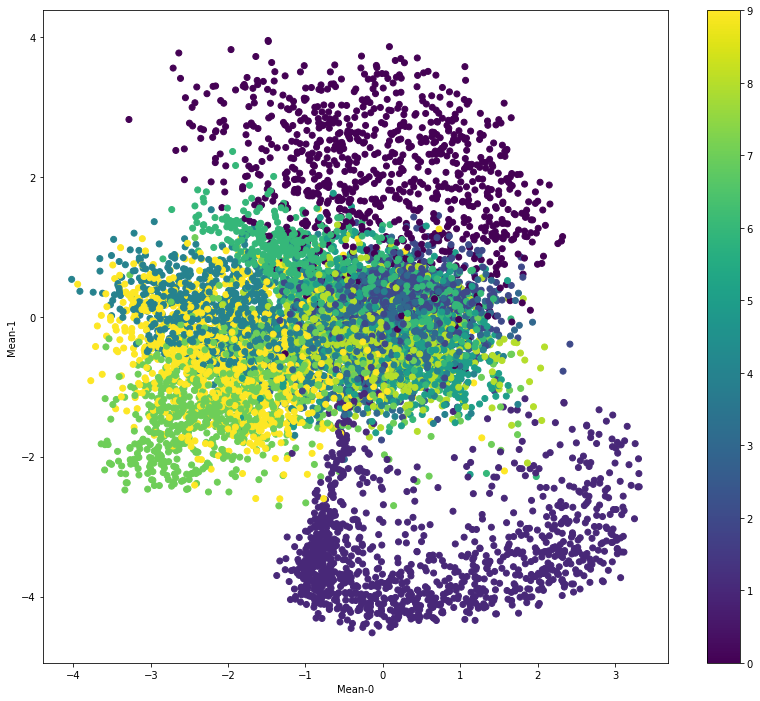

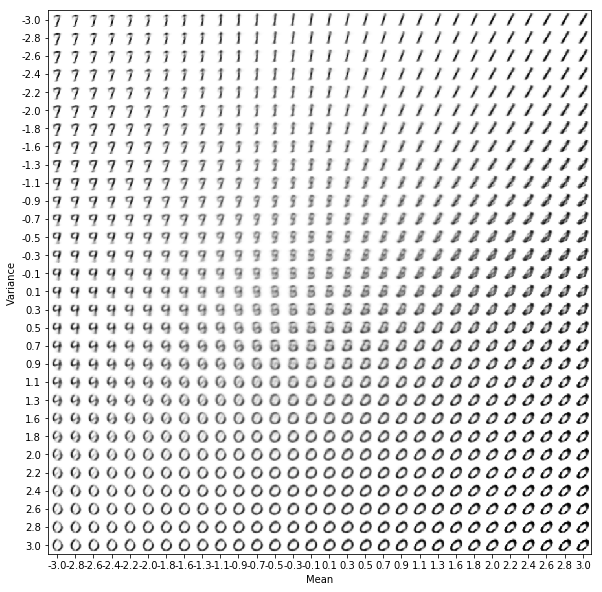

In [0]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

#Our loss is the sum of the reconstruction loss and the Kullback-leibler loss
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
#vae.summary()


vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

plot_results(latent_dim//2, models,data, batch_size=batch_size)

# Using Dimensions <br> Input Layer:784 <br> Latent variables:8 <br> Output Layer: 784 <br> Hidden layer: 256

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 18s 295us/step - loss: 176.1450 - val_loss: 139.6620
Epoch 2/20
60000/60000 [==============================] - 11s 188us/step - loss: 134.4809 - val_loss: 129.3078
Epoch 3/20
60000/60000 [==============================] - 12s 193us/step - loss: 127.8491 - val_loss: 124.9767
Epoch 4/20
60000/60000 [==============================] - 12s 194us/step - loss: 124.7251 - val_loss: 122.6801
Epoch 5/20
60000/60000 [==============================] - 11s 191us/step - loss: 122.7238 - val_loss: 120.9476
Epoch 6/20
60000/60000 [==============================] - 12s 195us/step - loss: 121.2901 - val_loss: 119.7941
Epoch 7/20
60000/60000 [==============================] - 12s 192us/step - loss: 120.1259 - val_loss: 118.7514
Epoch 8/20
60000/60000 [==============================] - 12s 194us/step - loss: 119.2092 - val_loss: 117.9621
Epoch 9/20
60000/60000 [==============================] - 11s 

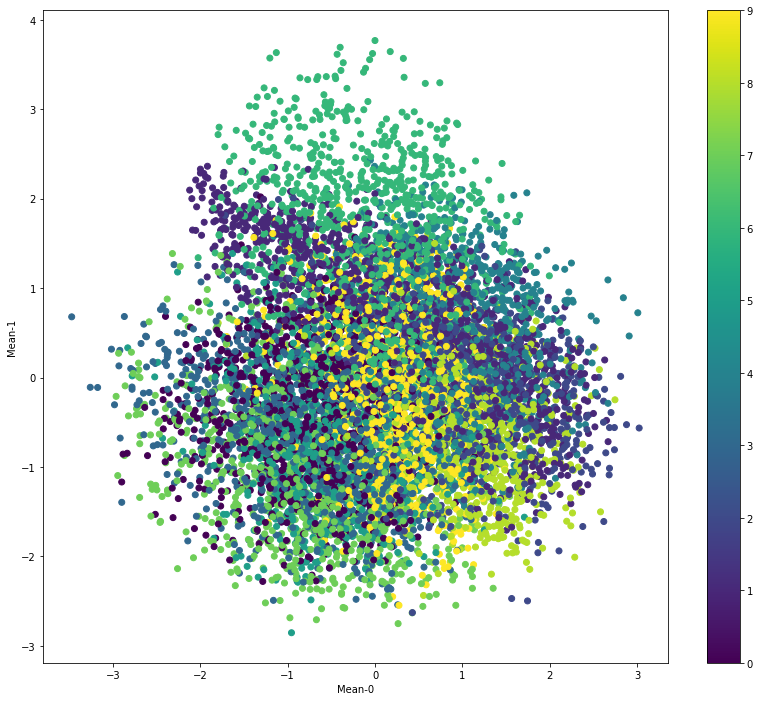

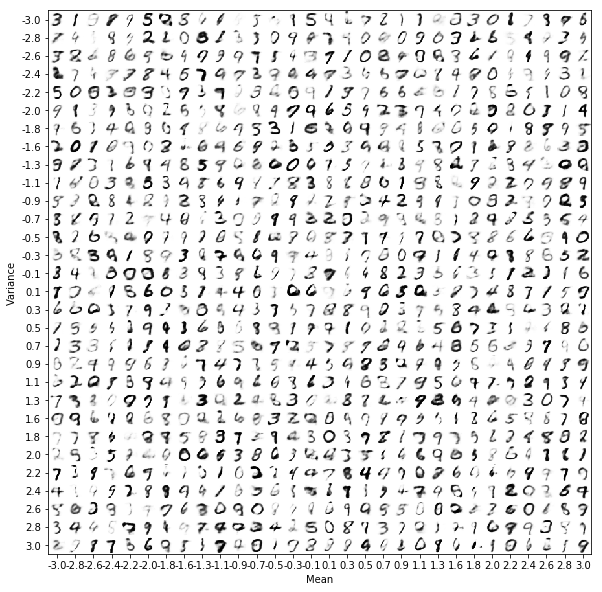

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#MNIST images are of size 28x28
image_size = 28
original_dim = image_size * image_size

#Now, we flatten/unroll and normalize the images
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Define parameters
input_size = (original_dim, )
intermediate_dim = 256
batch_size = 128
latent_dim = 8
epochs = 20

inputs = Input(shape=input_size)
x = Dense(intermediate_dim, activation='relu')(inputs)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

#Epsilon gen generates a shifted unit gaussian eliminating the need for solving a intranctable problem
z = Lambda(epsilon_gen, name='z')([z_mean, z_log_var])

# We create the encoder object here
encoder = Model(inputs, [z_mean, z_log_var, z])
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# We create the decoder model here
decoder = Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

#Our loss is the sum of the reconstruction loss and the Kullback-leibler loss
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
#vae.summary()


vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

plot_results(latent_dim//2, models,data, batch_size=batch_size)

# Using Dimensions <br> Input Layer:784 <br> Latent variables:16 <br> Output Layer: 784 <br> Hidden layer: 256

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 289us/step - loss: 170.9201 - val_loss: 132.2457
Epoch 2/20
60000/60000 [==============================] - 11s 188us/step - loss: 126.6200 - val_loss: 120.3620
Epoch 3/20
60000/60000 [==============================] - 11s 188us/step - loss: 119.1903 - val_loss: 115.8987
Epoch 4/20
60000/60000 [==============================] - 11s 189us/step - loss: 115.5238 - val_loss: 113.0281
Epoch 5/20
60000/60000 [==============================] - 11s 189us/step - loss: 113.2570 - val_loss: 111.4722
Epoch 6/20
60000/60000 [==============================] - 11s 188us/step - loss: 111.7065 - val_loss: 110.0560
Epoch 7/20
60000/60000 [==============================] - 11s 189us/step - loss: 110.6247 - val_loss: 109.5794
Epoch 8/20
60000/60000 [==============================] - 11s 188us/step - loss: 109.7200 - val_loss: 108.5403
Epoch 9/20
60000/60000 [==============================] - 11s 

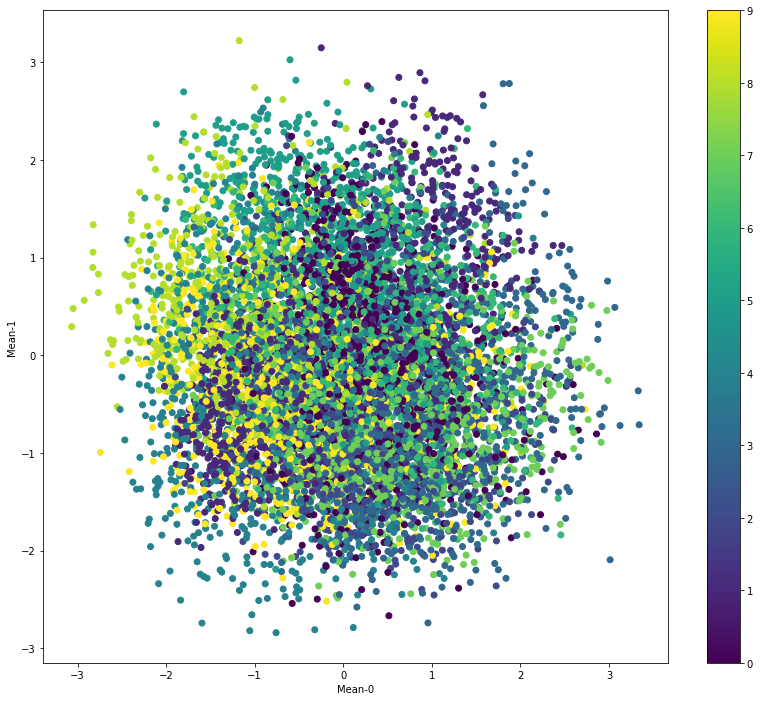

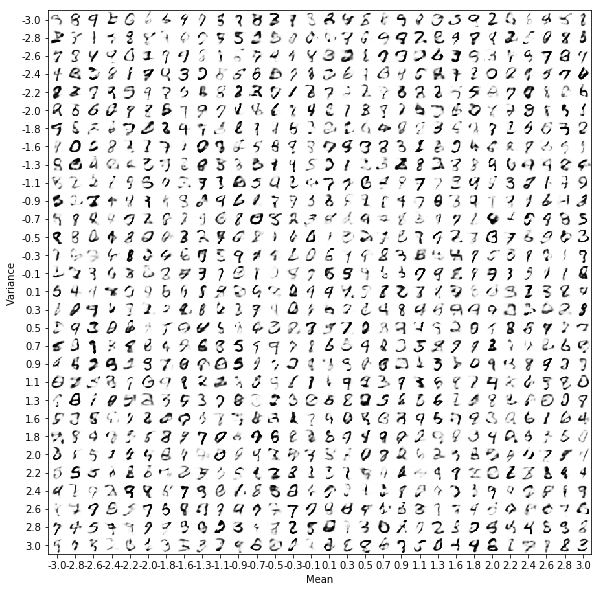

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#MNIST images are of size 28x28
image_size = 28
original_dim = image_size * image_size

#Now, we flatten/unroll and normalize the images
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Define parameters
input_size = (original_dim, )
intermediate_dim = 256
batch_size = 128
latent_dim = 16
epochs = 20

inputs = Input(shape=input_size)
x = Dense(intermediate_dim, activation='relu')(inputs)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

#Epsilon gen generates a shifted unit gaussian eliminating the need for solving a intranctable problem
z = Lambda(epsilon_gen, name='z')([z_mean, z_log_var])

# We create the encoder object here
encoder = Model(inputs, [z_mean, z_log_var, z])
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# We create the decoder model here
decoder = Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

#Our loss is the sum of the reconstruction loss and the Kullback-leibler loss
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
#vae.summary()


vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

plot_results(latent_dim//2, models,data, batch_size=batch_size)

Reference: https://www.youtube.com/watch?v=uaaqyVS9-rM&feature=youtu.be&t=19m42s